In [1]:
import tskit
import tszip
import numpy as np
import pandas as pd
import stdpopsim
from numpy.random import default_rng
import msprime
import pyreadr
import os

In [53]:
import msprime 
msprime.__version__

'1.0.2'

In [55]:
import stdpopsim
stdpopsim.__version__

'0.1.2'

In [2]:
pyreadr.__version__

'0.4.2'

In [56]:
4.33351e-08/3

1.4445033333333334e-08

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [4]:
BCFTOOLS = "/home/kele/programs/bcftools/bcftools-1.11/bcftools"

In [5]:
def get_ancestry_dosage(arr, n_anc):
    anc_dosage = np.zeros((arr.shape[0], int(arr.shape[1]/2)), dtype=np.half)
    if n_anc==3:
        assert (n_anc==3)
        a0 = arr[:, 0::3] # should be views
        a1 = arr[:, 1::3]
        a2 = arr[:, 2::3]
        anc_dosage[:, 0::3] = a0[:, ::2] + a0[:, 1::2]
        anc_dosage[:, 1::3] = a1[:, ::2] + a1[:, 1::2]
        anc_dosage[:, 2::3] = a2[:, ::2] + a2[:, 1::2]
    elif n_anc==4:
        assert (n_anc==4)
        a0 = arr[:, 0::4] # should be views
        a1 = arr[:, 1::4]
        a2 = arr[:, 2::4]
        a3 = arr[:, 3::4]
        anc_dosage[:, 0::4] = a0[:, ::2] + a0[:, 1::2]
        anc_dosage[:, 1::4] = a1[:, ::2] + a1[:, 1::2]
        anc_dosage[:, 2::4] = a2[:, ::2] + a2[:, 1::2]
        anc_dosage[:, 3::4] = a3[:, ::2] + a3[:, 1::2]   
    return anc_dosage

In [6]:
def r2_ancestry_dosage_PEARSON(true_dosage, pred_dosage, n_anc):
    per_anc = []
    for i in range(n_anc):
        per_anc.append(
            pearsonr(
                true_dosage[:,i::n_anc].ravel(),
                pred_dosage[:,i::n_anc].ravel()
            )[0]
        )
    per_ind = []
    for i in range(int(true_dosage.shape[1]/n_anc)):
        per_ind.append(
            pearsonr(
                true_dosage[:, i*n_anc:i*n_anc+n_anc].ravel(),
                pred_dosage[:, i*n_anc:i*n_anc+n_anc].ravel()
            )[0]
        )
    
    return(per_anc, per_ind)

# True ancestry

In [7]:
def load_true_la(path):
    return np.load(path)['arr']

def get_true_anc_dosage(true_la, n_anc):
    hap1 = np.zeros((true_la.shape[0], int(true_la.shape[1]/2*n_anc)), dtype = 'int8')
    hap2 = np.zeros((true_la.shape[0], int(true_la.shape[1]/2*n_anc)), dtype = 'int8')
    aa = np.arange(true_la[:, ::2].shape[1])*n_anc+true_la[:, ::2]
    bb = np.arange(true_la[:, 1::2].shape[1])*n_anc+true_la[:, 1::2]
    np.put_along_axis(hap1, aa, 1, axis=1)
    np.put_along_axis(hap2, bb, 1, axis=1)
    return hap1+hap2

## Load in the probablistic output of each method
Data frame with one row per site, 

Only every 5 sites represented in this file - not sure if it will always be intervals of 5 sites

After the index columns - each (individual) X (haplotype) X (population) has an entry. 

In [8]:
def load_rfmix_fb(path):
    rfmix_res = pd.read_csv(path, sep='\t', comment='#')
    # expand out to each site
    rfmix_res = np.repeat(rfmix_res.iloc[:, 4:].values, [5], axis = 0)
    return rfmix_res

In [9]:
def load_bmix(path):
    csv_path = path.replace('.vcf.gz', '.csv')
    !{BCFTOOLS} query -f '%CHROM, %POS, [%ANP1, %ANP2,]\n' {path} > {csv_path}
    bmix = pd.read_csv(csv_path, header=None)
    bmix = bmix.dropna(axis=1)
    return(bmix.iloc[:,2:].values)

In [10]:
def load_mosaic(path):
    mr = pyreadr.read_r(path)['arr'].astype(np.half)
    mr = mr.to_numpy().T.reshape((mr.shape[2],-1), order='C')
    return mr

In [11]:
def plot_ancestry_dosage(pred_dosage, start_index, n_anc, reference_dosage=None, title = None):
    """
    only works for 3 ancestries
    """
    colors = ['blue', 'orange', 'green', 'grey']
    
    fig, ax = plt.subplots(figsize = (12, n_anc*1.5), nrows=n_anc, sharex=True, sharey=True)
    
    
    f = []
    for i in range(n_anc):
        l, = ax[i].plot(pred_dosage[:, start_index+i], c=colors[i])
        ax[i].set_ylim([-.05, 2.05])
        f.append(l)
        
    plt.legend(f, [f'pop{p}' for p in range(n_anc)])
    
    if reference_dosage is not None:
        for i in range(n_anc):
            l, = ax[i].plot(reference_dosage[:, start_index+i], c=colors[i], #alpha=.5, 
                            ls='dotted')

    fig.tight_layout()
    sns.despine(bottom=True)
    if title:
        ax[0].set_title(title)
    else:
        ax[0].set_title('Ancestry dosage')
    ax[-1].set_xlabel('Site number ')

## 3 population paths

In [32]:
n_anc=3
base_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_100K_20/SUMMARY"
true_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_100K_20/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_100K_20/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_100K_20/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_100K_20/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

RFMix2
0.9812619409914861 [0.9842546029786019, 0.978662371109091, 0.9808688488867656]
MOSAIC
0.9786445826403783 [0.9783711699060285, 0.9773850049879298, 0.9801775730271771]
bmix
0.9779368141554196 [0.9703855197937518, 0.9818012882941787, 0.9816236343783281]


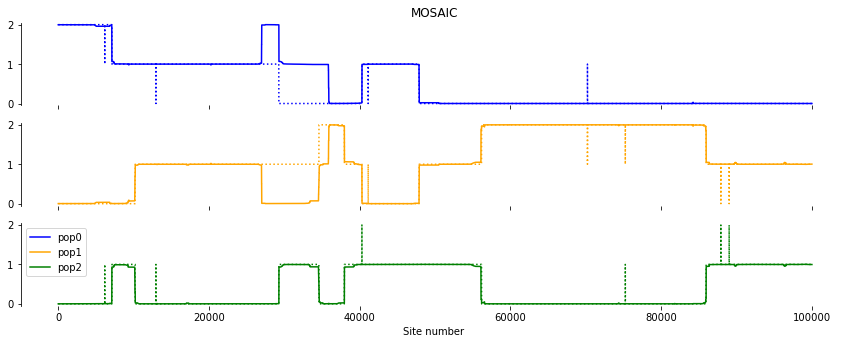

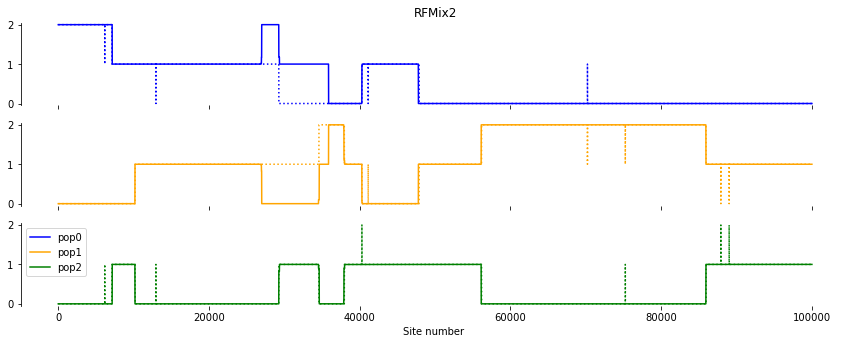

In [33]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=6, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'MOSAIC')
plot_ancestry_dosage(rfmix_anc_dosage, start_index=6, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

In [34]:
n_anc=3
base_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_200K_20/SUMMARY"
true_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_200K_20/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_200K_20/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_200K_20/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_200K_20/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

RFMix2
0.9806936095827891 [0.9837382877789128, 0.97810842416538, 0.9802341168040742]
MOSAIC
0.9412119076837278 [0.9319884938840702, 0.9521721258061298, 0.939475103360983]
bmix
0.9813284989690746 [0.9862005112354568, 0.9768795031910407, 0.9809054824807263]


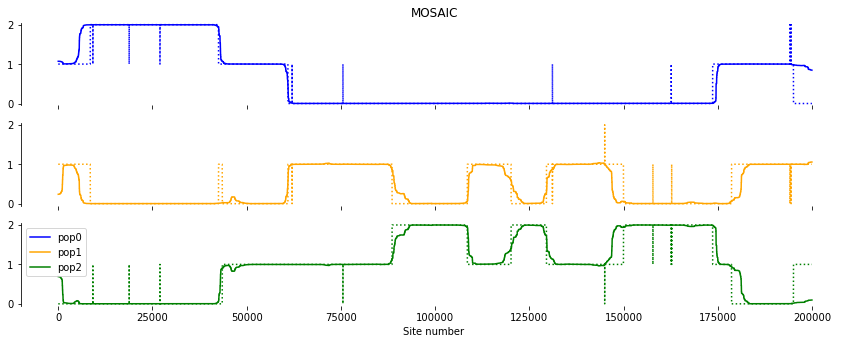

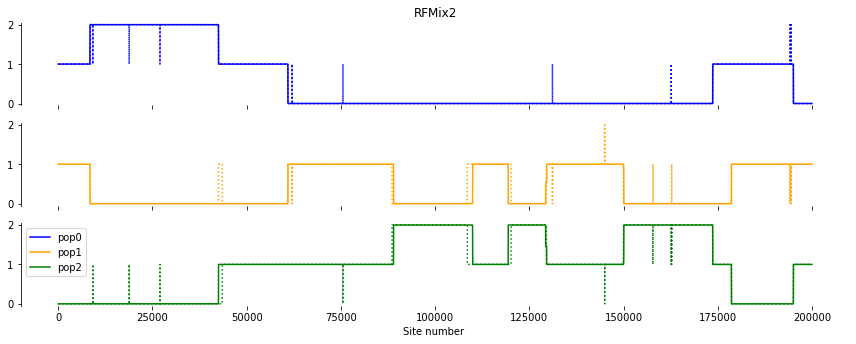

In [35]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=0, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'MOSAIC')
plot_ancestry_dosage(rfmix_anc_dosage, start_index=0, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

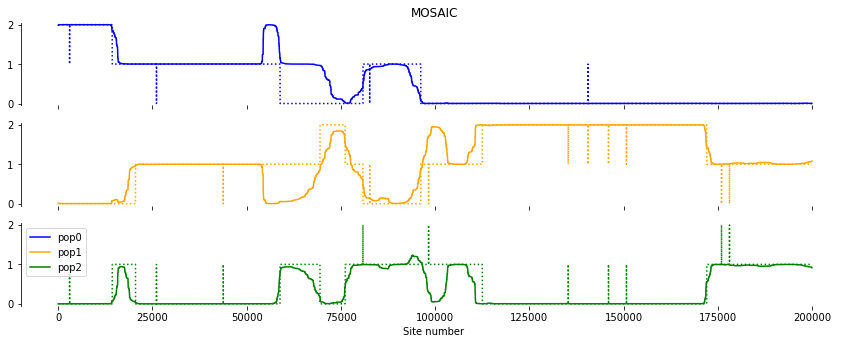

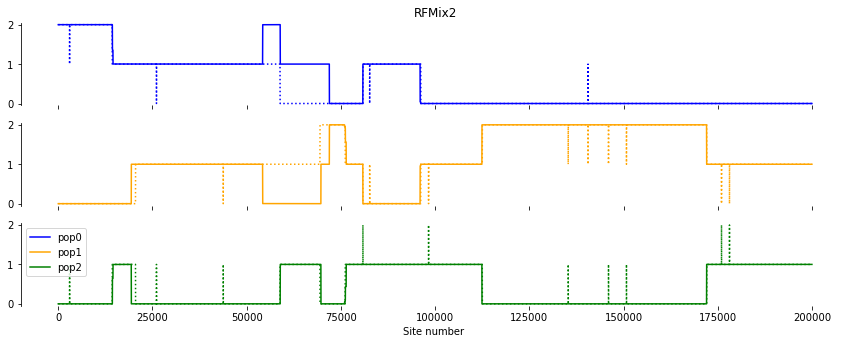

In [36]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=6, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'MOSAIC')
plot_ancestry_dosage(rfmix_anc_dosage, start_index=6, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

In [45]:
n_anc=3
base_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_300K_20/SUMMARY"
true_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_300K_20/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_300K_20/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_300K_20/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_300K_20/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

RFMix2
0.9806353246299085 [0.9836128843857624, 0.9778843016627453, 0.9804087878412175]
MOSAIC
0.6037442286392546 [0.5298184183078799, 0.7075630193780352, 0.5738512482318486]
bmix
0.9819258335481343 [0.977388912344104, 0.9823031943008436, 0.9860853939994552]


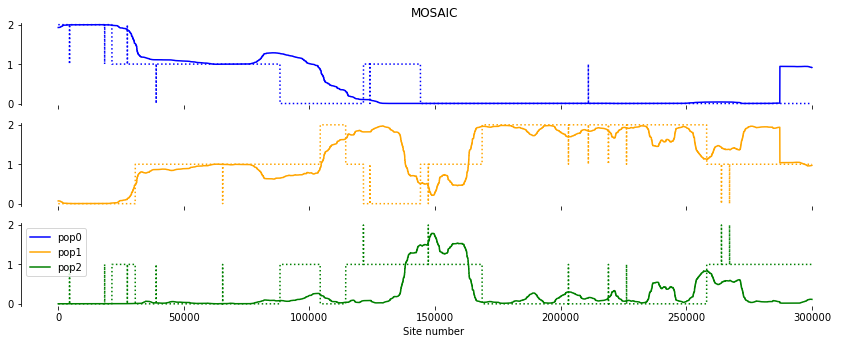

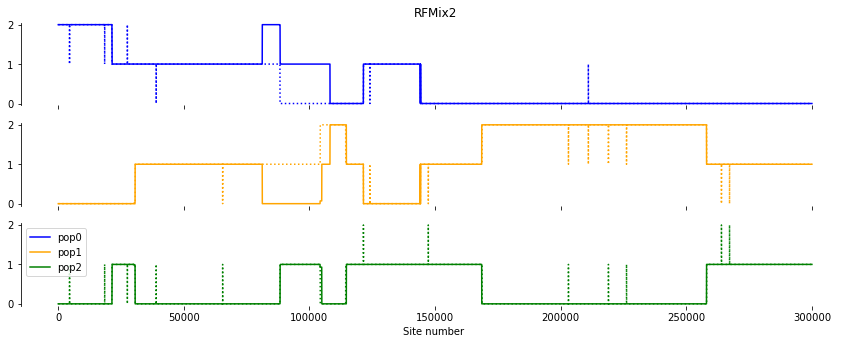

In [38]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=6, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'MOSAIC')
plot_ancestry_dosage(rfmix_anc_dosage, start_index=6, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

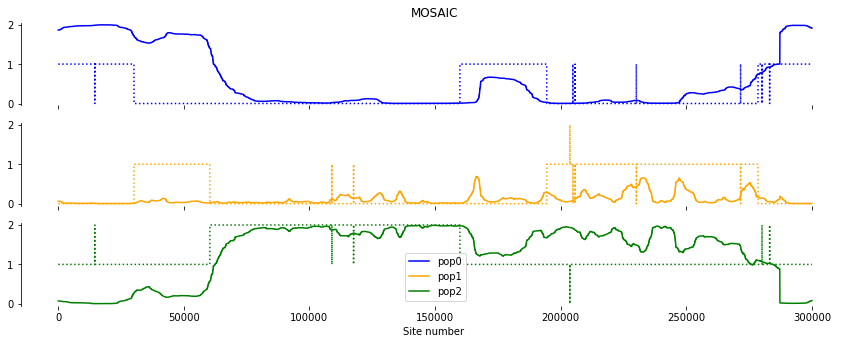

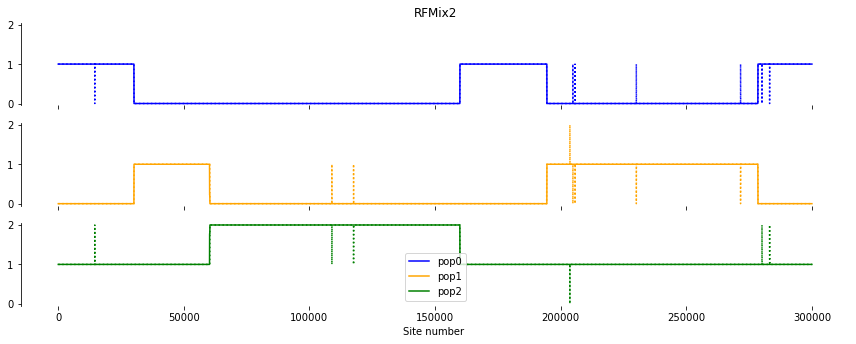

In [46]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=9, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'MOSAIC')
plot_ancestry_dosage(rfmix_anc_dosage, start_index=9, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

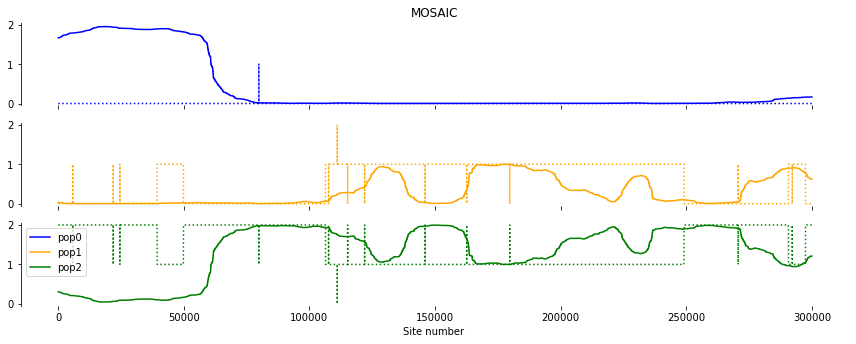

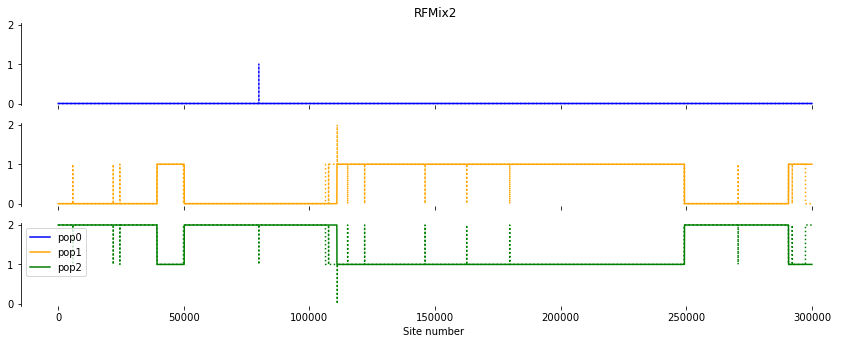

In [47]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=12, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'MOSAIC')
plot_ancestry_dosage(rfmix_anc_dosage, start_index=12, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

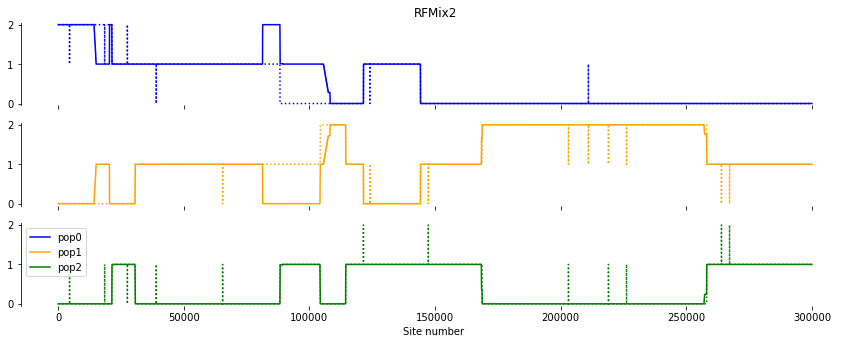

In [39]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=6, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

In [52]:
mosaic_ind_r2, np.argsort(mosaic_ind_r2)


([0.7050779356300311,
  0.9266135622438122,
  0.7271832125924894,
  0.6347669298511945,
  0.462591126390631,
  0.43086881570250163,
  0.1764393272330578,
  0.4463987182826191,
  0.5145962763040867,
  0.2589375302268791,
  0.646555692518796,
  0.5668887264140284,
  0.32093217104280247,
  0.7505721841502214,
  0.383508881254795,
  0.5979893391532269,
  0.7487076645244743,
  0.8385207476233003,
  0.4719905786873286,
  0.5526359420299559],
 array([ 6,  9, 12, 14,  5,  7,  4, 18,  8, 19, 11, 15,  3, 10,  0,  2, 16,
        13, 17,  1]))

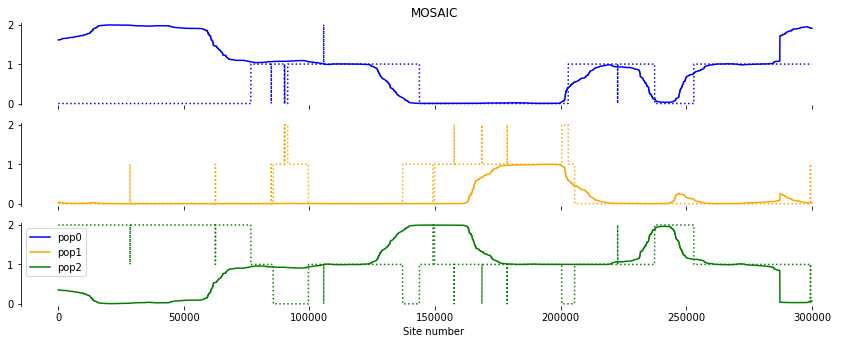

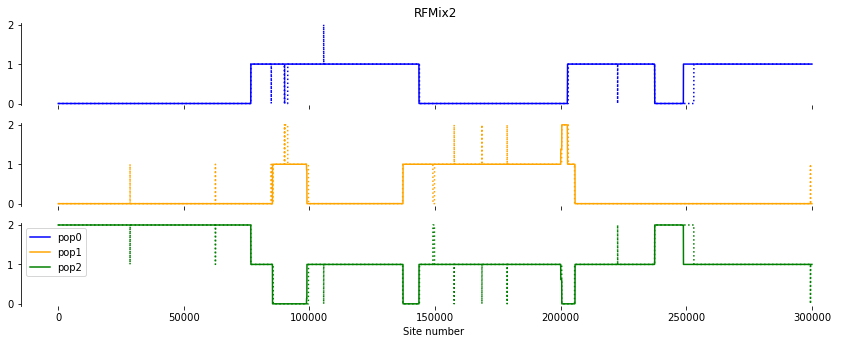

In [50]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=6*3, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'MOSAIC')
plot_ancestry_dosage(rfmix_anc_dosage, start_index=6*3, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

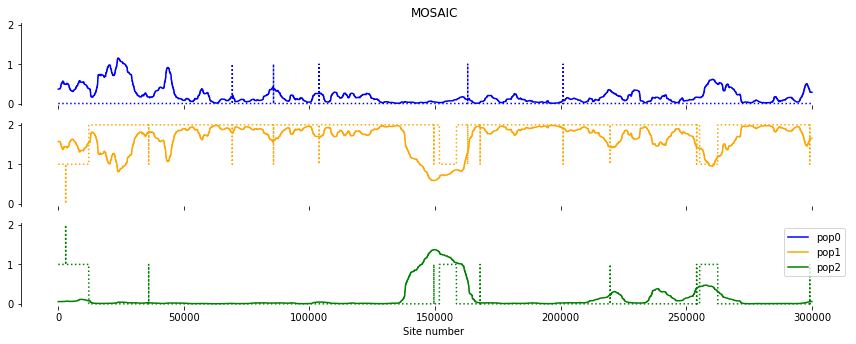

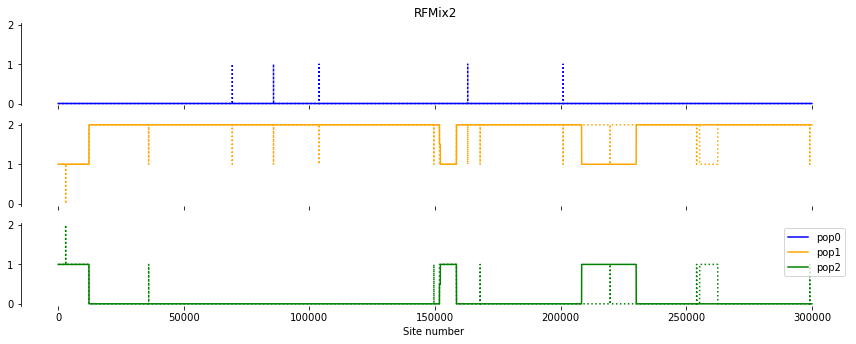

In [51]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=1*3, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'MOSAIC')
plot_ancestry_dosage(rfmix_anc_dosage, start_index=1*3, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

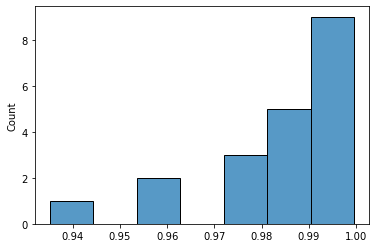

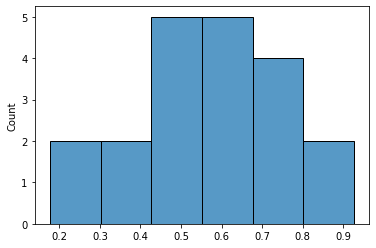

<AxesSubplot:ylabel='Count'>

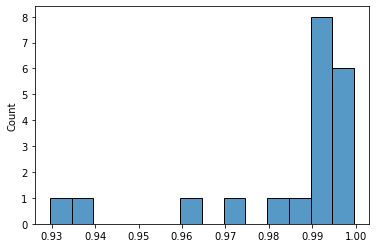

In [44]:
sns.histplot(rfmix_ind_r2)
plt.show()
sns.histplot(mosaic_ind_r2)
plt.show()
sns.histplot(bmix_ind_r2)

In [40]:
n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_b/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_b/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_b/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_b/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_b/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

RFMix2
0.9599919101878823 [0.9719455786975292, 0.9491044134245316, 0.9589257384415861]
MOSAIC
0.952388049019449 [0.9496574674144709, 0.9528247920250454, 0.9546818876188308]
[W::hts_idx_load3] The index file is older than the data file: /home/kele/Documents/lai/report/results/3pop_b/bmix/bmix.anc.vcf.gz.csi
bmix
0.9766295813660376 [0.9805596161176274, 0.9725791116714588, 0.9767500163090264]


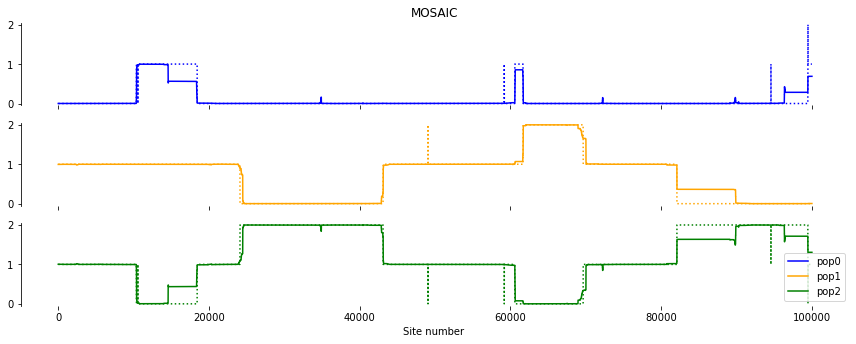

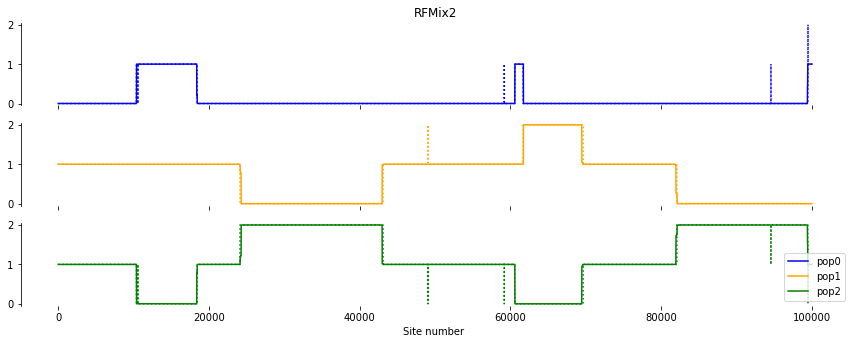

In [45]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'MOSAIC')
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

In [26]:
n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_d/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_d/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_d/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_d/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_d/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

RFMix2
0.9653883706281556 [0.9761054985034314, 0.9548585771033388, 0.9652010362776967]
MOSAIC
0.8841202809364531 [0.9329766311265839, 0.8537489477188244, 0.8656352639639514]
[W::vcf_parse] Contig 'chr22' is not defined in the header. (Quick workaround: index the file with tabix.)
bmix
0.9753054395439982 [0.9749437039910106, 0.9774582723397397, 0.9735143423012445]


In [46]:
n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_e/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_e/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_e/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_e/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_e/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

RFMix2
0.9665838263030296 [0.972789240693921, 0.9590413026741804, 0.9679209355409876]
MOSAIC
-0.43315582197668134 [-1.113255980114801, -0.16498157324535612, -0.021229912569886933]
[W::hts_idx_load3] The index file is older than the data file: /home/kele/Documents/lai/report/results/3pop_e/bmix/bmix.anc.vcf.gz.csi
bmix
0.9799313390448082 [0.9819105788200673, 0.9759578765963072, 0.9819255617180503]


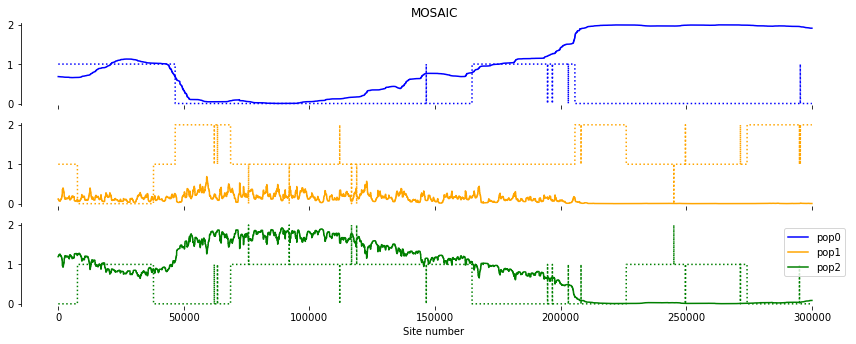

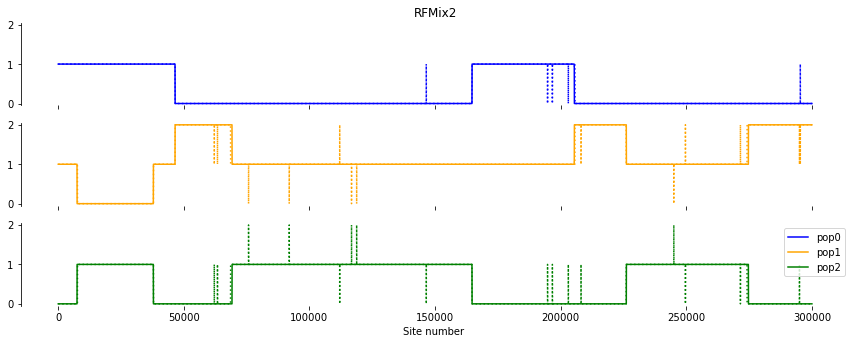

In [47]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'MOSAIC')
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage, title = 'RFMix2')

In [34]:
print('3pop_b, PEARSON')
n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_b/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_b/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_b/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_b/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_b/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

3pop_b, PEARSON
RFMix2
0.9799787368983138 [0.9859932490366351, 0.9745116860459441, 0.9794312756123621]
MOSAIC
0.975984632655901 [0.9746128773454565, 0.9761953124836382, 0.977145708138608]
[W::hts_idx_load3] The index file is older than the data file: /home/kele/Documents/lai/report/results/3pop_b/bmix/bmix.anc.vcf.gz.csi
bmix
0.9883154343613062 [0.9902719183877408, 0.9862960632798814, 0.9883783214162966]


In [35]:
print('3pop_d, PEARSON')

n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_d/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_d/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_d/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_d/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_d/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

3pop_d, PEARSON
RFMix2
0.9827173843334919 [0.9880707169242702, 0.9774652951946659, 0.9826161408815395]
MOSAIC
0.9411401134755919 [0.9663470146372822, 0.9253819133454653, 0.931691412444028]
[W::vcf_parse] Contig 'chr22' is not defined in the header. (Quick workaround: index the file with tabix.)
bmix
0.9877384567647445 [0.9876174152318233, 0.9887511695010742, 0.986846785561336]


In [36]:
print('3pop_e, PEARSON')

n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_e/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_e/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_e/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_e/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_e/bmix/bmix.anc.vcf.gz'

true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)

rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
print('RFMix2')
print(np.mean(rfmix_anc_r2), rfmix_anc_r2)

mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
print('MOSAIC')
print(np.mean(mosaic_anc_r2), mosaic_anc_r2)

bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage_PEARSON(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
print('bmix')
print(np.mean(bmix_anc_r2), bmix_anc_r2)

3pop_e, PEARSON
RFMix2
0.9832950210080259 [0.9864079589948922, 0.9795283743374978, 0.9839487296916878]
MOSAIC
0.485981247509592 [0.48455383951706443, 0.4692988576940523, 0.5040910453176592]
[W::hts_idx_load3] The index file is older than the data file: /home/kele/Documents/lai/report/results/3pop_e/bmix/bmix.anc.vcf.gz.csi
bmix
0.9899436418809432 [0.9909546822120023, 0.9879383792793492, 0.9909378641514778]


## 4 population paths

In [ ]:
n_anc=4
base_path = "/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/SUMMARY"
true_path = "/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/true_local_ancestry.site_matrix.npz"
rf_fb_path =  "/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/RFMix2/rfmix2.fb.tsv"
mosaic_path = '/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/MOSAIC/la_probs.RData'
bmixpath = '/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/bmix/bmix.anc.vcf.gz'

# TODO
    - move to Snakemake
    - write out the diploid ancestry dosage matrices
    - write out the accuracy for each in a file

In [50]:
n_anc=3
base_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_2/SUMMARY"
true_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_2/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_2/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_2/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_2/bmix/bmix.anc.vcf.gz'


In [51]:
true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)


In [52]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
np.mean(rfmix_anc_r2), rfmix_anc_r2

(0.9623839622451981,
 [0.9705562736879104, 0.953021601927494, 0.9635740111201896])

In [53]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage,
    n_anc=n_anc
)
np.mean(rfmix_anc_r2), rfmix_anc_r2

(0.9623839622451981,
 [0.9705562736879104, 0.953021601927494, 0.9635740111201896])

In [54]:
mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
np.mean(mosaic_anc_r2), mosaic_anc_r2

(0.957680114385168,
 [0.9579496426109032, 0.954251506428117, 0.9608391941164838])

In [55]:
bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
np.mean(bmix_anc_r2), bmix_anc_r2

(0.9789473261634574,
 [0.9851471720740084, 0.9722837452478683, 0.9794110611684953])

In [56]:
#plot_ancestry_dosage(true_anc_dosage, start_index=0, n_anc=n_anc, reference_dosage=None)

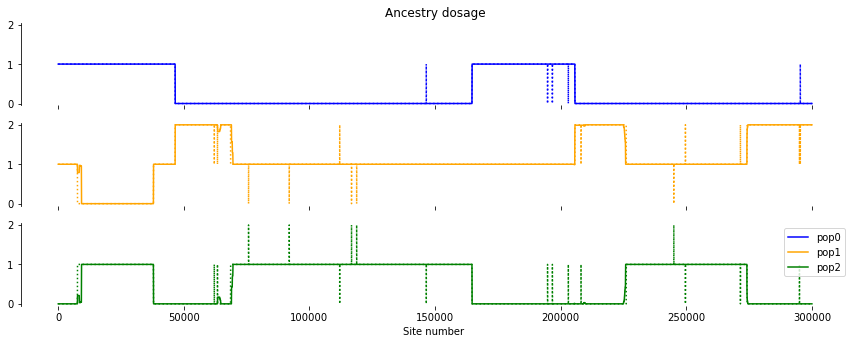

In [37]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage)

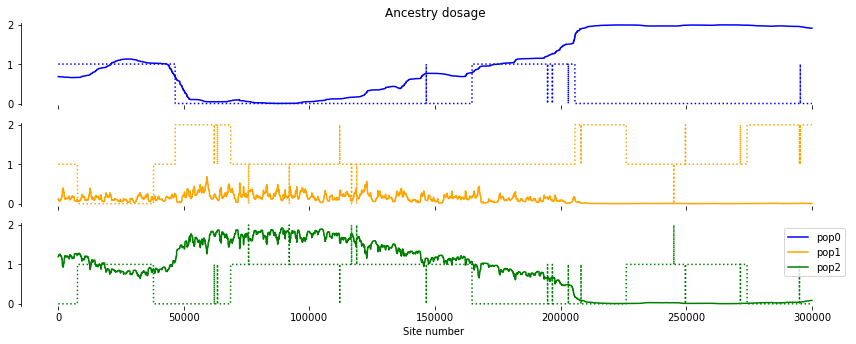

In [38]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage)

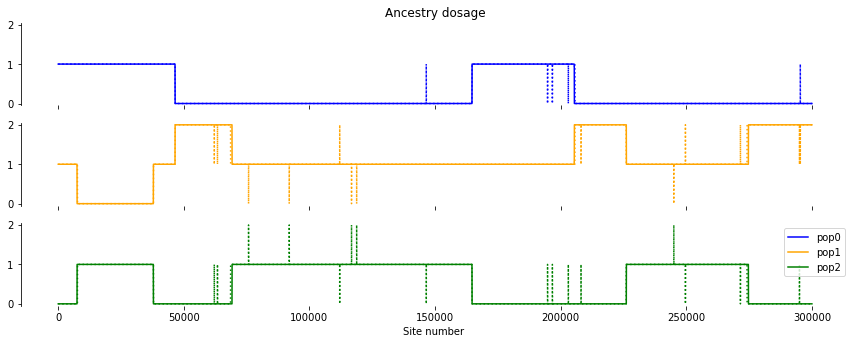

In [39]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage)

In [41]:
n_anc=3
base_path = "/home/kele/Documents/lai/report/results/3pop_d/SUMMARY"
true_path = "/home/kele/Documents/lai/report/results/3pop_d/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/report/results/3pop_d/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/report/results/3pop_d/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/Documents/lai/report/results/3pop_d/bmix/bmix.anc.vcf.gz'

In [42]:
true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)


In [43]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
np.mean(rfmix_anc_r2), rfmix_anc_r2

(0.9653883706281556,
 [0.9761054985034314, 0.9548585771033388, 0.9652010362776967])

In [44]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage,
    n_anc=n_anc
)
np.mean(rfmix_anc_r2), rfmix_anc_r2

(0.9653883706281556,
 [0.9761054985034314, 0.9548585771033388, 0.9652010362776967])

In [45]:
mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
np.mean(mosaic_anc_r2), mosaic_anc_r2

(0.8841202809364531,
 [0.9329766311265839, 0.8537489477188244, 0.8656352639639514])

In [46]:
bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
np.mean(bmix_anc_r2), bmix_anc_r2

[W::vcf_parse] Contig 'chr22' is not defined in the header. (Quick workaround: index the file with tabix.)


(0.9753054395439982,
 [0.9749437039910106, 0.9774582723397397, 0.9735143423012445])

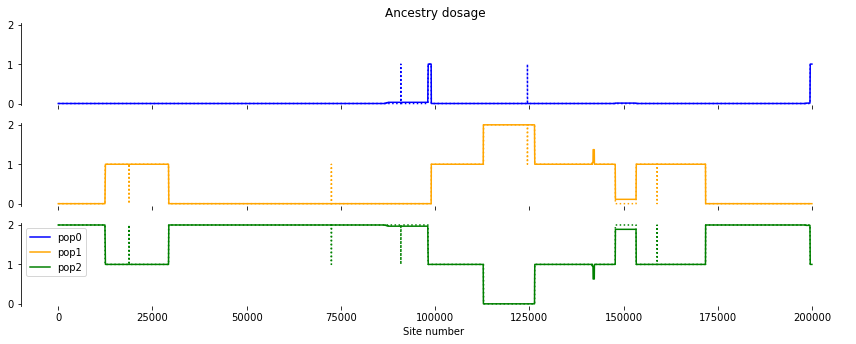

In [47]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage)

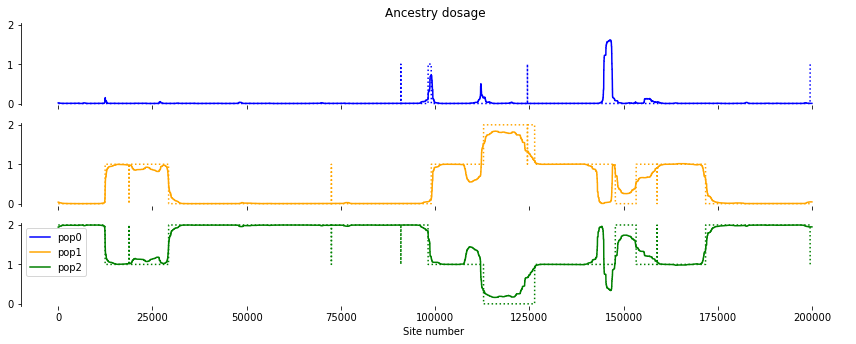

In [48]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage)

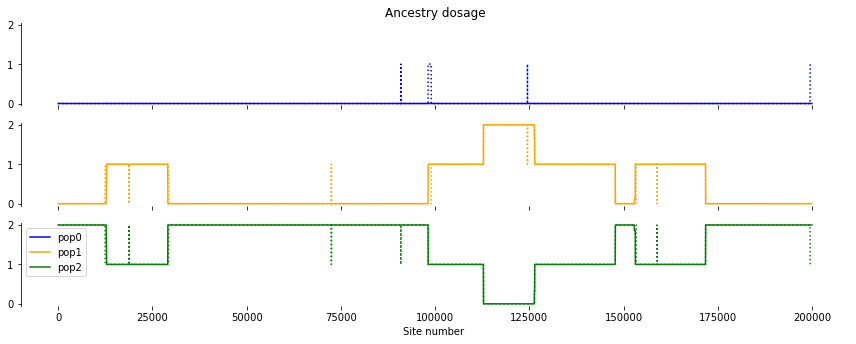

In [49]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, n_anc=n_anc, reference_dosage=true_anc_dosage)

In [ ]:
plot_ancestry_dosage(true_anc_dosage, start_index=0, n_anc=n_anc, reference_dosage=None)

In [ ]:
plot_ancestry_dosage(bmix_anc_dosage , start_index=4, n_anc=n_anc, reference_dosage=true_anc_dosage)

In [ ]:
plot_ancestry_dosage(mosaic_anc_dosage , start_index=4, n_anc=n_anc, reference_dosage=true_anc_dosage)

## Why is mosaic failing

In [ ]:
mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)


In [ ]:
import glob 
mosaic_path = glob.glob('/home/kele/Documents/lai/lai-sim/results/*/*/*/MOSAIC/*.RData')[1]
#pyreadr.read_r(mosaic_path)

In [ ]:
#load_mosaic(mosaic_path)

In [ ]:
!ls /home/kele/3pop_c/MOSAIC/*.RData

In [ ]:
# run in R
library('MOSAIC')

model_results = '/home/kele/3pop_c/MOSAIC/admixed.RData'
la_results = '/home/kele/3pop_c/MOSAIC/localanc_admixed.RData'
mosaic_input_dir = '/home/kele/3pop_c/MOSAIC/input/'

load(model_results)
load(la_results)
# localanc gives the local ancestry at each grid point
# get local ancestry probabilities at each SNP
local_pos=grid_to_pos(localanc, mosaic_input_dir, g.loc, chrnos)
dims = dim(local_pos[[1]])
# convert to array and then export
arr = array(unlist(local_pos, use.names=FALSE), dims)

In [ ]:
arr2 = array(unlist(local_pos, use.names=FALSE), dims)

In [ ]:
output_path = '/home/kele/3pop_c/MOSAIC/la_probs2.RData'
save(arr, file = output_path)
#save(arr, file = simple_output)

In [ ]:
#pyreadr.read_r('/home/kele/3pop_c/MOSAIC/la_probs2.RData', use_objects=['arr'])
pyreadr.read_r('/home/kele/3pop_c/MOSAIC/la_probs.rds')

In [ ]:
pyreadr.read_r('/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_5/MOSAIC/la_probs.RData')


In [ ]:
pyreadr.read_r('/home/kele/3pop_c/MOSAIC/la_probs2.RData', use_objects=['arr'])

In [ ]:
true_anc_dosage

In [ ]:
bb = load_true_la(true_path)
bb.shape

In [ ]:
!wc -l /home/kele/3pop_c/site.positions


In [ ]:
aa

In [ ]:
sqdif = ((true_anc_dosage - bmix_anc_dosage).astype('float')**2).sum().sum()

In [ ]:
sqdif/ (true_anc_dosage.shape[0]*true_anc_dosage.shape[1])

In [ ]:
np.sqrt(sqdif/(true_anc_dosage.shape[0]*true_anc_dosage.shape[1]))

In [ ]:
sns.histplot(bmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(bmix_ind_r2)), sorted(bmix_ind_r2))
plt.show()
np.mean(bmix_anc_r2), np.mean(bmix_ind_r2)

In [ ]:
sns.histplot(rfmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(rfmix_ind_r2)), sorted(rfmix_ind_r2))
plt.show()
np.mean(rfmix_anc_r2), np.mean(rfmix_ind_r2)

In [ ]:
## Write R2 tables
with open(os.path.join(base_path, 'R2_score.ancestry.tsv'), 'w') as OUTFILE:
    OUTFILE.write('\t'.join(['method'] + [f'anc_{x}' for x in range(nanc)]) + '\n')
    OUTFILE.write('\t'.join(['rfmix2'] + [str(x) for x in rfmix_anc_r2])  + '\n')
    OUTFILE.write('\t'.join(['mosaic'] + [str(x) for x in mosaic_anc_r2])  + '\n')
    OUTFILE.write('\t'.join(['bmix'] + [str(x) for x in bmix_anc_r2])  + '\n')
    
with open(os.path.join(base_path, 'R2_score.individuals.tsv'), 'w') as OUTFILE:
    OUTFILE.write('\t'.join(['method'] + [f'ind_{x}' for x in range(len(bmix_ind_r2))]) + '\n')
    OUTFILE.write('\t'.join(['rfmix2'] + [str(x) for x in rfmix_ind_r2])  + '\n')
    OUTFILE.write('\t'.join(['mosaic'] + [str(x) for x in mosaic_ind_r2])  + '\n')
    OUTFILE.write('\t'.join(['bmix'] + [str(x) for x in bmix_ind_r2])  + '\n')

In [ ]:
assert False

In [ ]:
plot_ancestry_dosage(true_anc_dosage, start_index=3, reference_dosage=None)

In [ ]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

In [ ]:
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage,
    nanc=3
)
sns.histplot(rfmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(rfmix_ind_r2)), sorted(rfmix_ind_r2))
plt.show()
np.mean(rfmix_anc_r2), np.mean(rfmix_ind_r2)

# Mosaic
Data frame with one row per site. 
after the index columns - each (individual) X (haplotype) X (ancestry) has an entry. 

In [ ]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

In [ ]:
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    nanc=3
)
sns.histplot(mosaic_ind_r2)
plt.show()
plt.scatter(np.arange(len(mosaic_ind_r2)), sorted(mosaic_ind_r2))
np.mean(mosaic_anc_r2), np.mean(mosaic_ind_r2)

In [ ]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

# bmix

In [ ]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

In [ ]:
!{BCFTOOLS} query -f '%CHROM, %POS, [%ANP1, %ANP2,]\n' {bmixpath} > {bmixpath.replace('.vcf.gz', '.csv')}

In [ ]:
bmix = pd.read_csv(bmixpath.replace('.vcf.gz', '.csv'), header = None)
bmix = bmix.dropna(axis=1)
bmix = bmix.iloc[:,2:]
bmix_anc_dosage = get_ancestry_dosage(bmix.values)

In [ ]:
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    nanc=3
)
np.mean(bmix_anc_r2), np.mean(bmix_ind_r2)

In [ ]:
sns.histplot(bmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(bmix_ind_r2)), sorted(bmix_ind_r2))
np.where(bmix_ind_r2 == np.min(bmix_ind_r2))
plt.show()

In [ ]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

## There is not a huge correlation in the indiviudal level accuracy of the various methods here

In [ ]:
r2_df = pd.DataFrame(data = {'bmix':bmix_ind_r2, 'rfmix':rfmix_ind_r2, 'mosaic':mosaic_ind_r2})

In [ ]:
pearsonr(r2_df['bmix'], r2_df['mosaic'])[0]**2, pearsonr(r2_df['bmix'], r2_df['rfmix'])[0]**2, pearsonr(r2_df['mosaic'], r2_df['rfmix'])[0]**2

In [ ]:
sns.pairplot(r2_df,
             plot_kws = {'alpha': 0.6, 's': 20, 'edgecolor': 'k'})

In [ ]:
sns.jointplot(data = r2_df, x='bmix', y='rfmix', color="#4CB391", kind="reg")

In [ ]:
def plot_ancestry_dosage(pred_dosage, start_index, n_anc, reference_dosage=None):
    """
    only works for 3 ancestries
    """
    fig, ax = plt.subplots(figsize = (12, n_anc*1.5), nrows=n_anc, sharex=True, sharey=True)
    
    l0, = ax[0].plot(pred_dosage[:, start_index+0], c='b')
    l1, = ax[1].plot(pred_dosage[:, start_index+1], c='orange')
    l2, = ax[2].plot(pred_dosage[:, start_index+2], c='green')
    
    plt.legend([l0, l1, l2], ['pop0', 'pop1', 'pop2'])

    
    if reference_dosage is not None:
        l0, = ax[0].plot(reference_dosage[:, start_index+0], c='b', alpha=.5, ls='--')
        l1, = ax[1].plot(reference_dosage[:, start_index+1], c='orange', alpha=.5, ls='--')
        l2, = ax[2].plot(reference_dosage[:, start_index+2], c='green', alpha=.5, ls='--')

    fig.tight_layout()
    sns.despine(bottom=True)
    ax[0].set_title('Ancestry dosage')
    ax[-1].set_xlabel('Site number ')